<a href="https://colab.research.google.com/github/fabriziobasso/kaggle/blob/main/Timeseries_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Timeseries classification from scratch**

**Date created:** 2020/07/21<br>
**Last modified:** 2023/11/10<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archiv

## **Introduction**

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).e.

## Setup

In [1]:
%%capture
run_n = 0
if run_n==0:
  #!pip install tensorflow-addons
  #!pip install shap
  #!pip install eli5
  #!pip install tf-nightly
  #!pip install -U scikit-learn==1.2.0
  !pip install catboost
  #!pip install haversine
  #!pip install pytorch-forecasting
  #!pip install umap-learn
  #!pip install reverse_geocoder
  #!pip install --upgrade protobuf
  !pip install colorama
  #!pip install imbalanced-learn
  !pip install optuna
  !pip install optuna-integration
  #!pip install pygam
  !pip install keras-tuner --upgrade
  #!pip install pycaret
  #!pip install lightning==2.0.1
  !pip install keras-nlp
  #!pip install MiniSom
  !pip install category_encoders
  !pip install BorutaShap
  !pip install feature-engine
  #!pip install scikit-learn==1.4.1
  !pip install scikit-lego

In [2]:
import pandas as pd
import numpy as np
from pickle import load, dump
import json
#import calplot as cal

# Graphic Libraries:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# Set Style
sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5});
sns.despine(left=True, bottom=True, top=False, right=False);
mpl.rcParams['figure.dpi'] = 120;
mpl.rc('axes', labelsize=12);
plt.rc('xtick',labelsize=10);
plt.rc('ytick',labelsize=10);

mpl.rcParams['axes.spines.top'] = False;
mpl.rcParams['axes.spines.right'] = False;
mpl.rcParams['axes.spines.left'] = True;

# Style Import
from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

# Palette Setup
colors = ['#FB5B68','#FFEB48','#2676A1','#FFBDB0',]
colormap_0 = mpl.colors.LinearSegmentedColormap.from_list("",colors)
palette_1 = sns.color_palette("coolwarm", as_cmap=True)
palette_2 = sns.color_palette("YlOrBr", as_cmap=True)
palette_3 = sns.light_palette("red", as_cmap=True)
palette_4 = sns.color_palette("viridis", as_cmap=True)
palette_5 = sns.color_palette("rocket", as_cmap=True)
palette_6 = sns.color_palette("GnBu", as_cmap=True)
palette_7 = sns.color_palette("tab20c", as_cmap=False)
palette_8 = sns.color_palette("Set2", as_cmap=False)

palette_custom = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palette_9 = sns.color_palette(palette_custom, as_cmap=False)

# tool for Excel:
from openpyxl import load_workbook, Workbook
from openpyxl.drawing.image import Image
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment
from openpyxl.worksheet.cell_range import CellRange

from openpyxl.formatting import Rule
from openpyxl.styles import Font, PatternFill, Border
from openpyxl.styles.differential import DifferentialStyle

# Bloomberg
#from xbbg import blp

# Time Management
from tqdm import tqdm
from datetime import date
from datetime import datetime
from pandas.tseries.offsets import BMonthEnd, QuarterEnd
import datetime
from pandas.tseries.offsets import BDay # BDay is business day, not birthday...
import datetime as dt
import click
import glob
import os
import gc
import re
import string

from ipywidgets import AppLayout
from ipywidgets import Dropdown, Layout, HTML, AppLayout, VBox, Label, HBox, BoundedFloatText, interact, Output

#from my_func import *


import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

import keras
import tensorflow as tf

#from my_func import *

# preprocessing modules
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, GroupKFold, GridSearchCV, RepeatedStratifiedKFold, cross_val_predict

from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   RobustScaler,
                                   PowerTransformer,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder,
                                   QuantileTransformer,
                                   PolynomialFeatures)

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import FunctionTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

<Figure size 640x480 with 0 Axes>

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [3]:
%%time

# Setting rc parameters in seaborn for plots and graphs-
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,
        });

# Color printing
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL);

# Making sklearn pipeline outputs as dataframe:-
pd.set_option('display.max_columns', 100);
pd.set_option('display.max_rows', 50);

sns.set_style("whitegrid",{"grid.linestyle":"--", 'grid.linewidth':0.2, 'grid.alpha':0.5})
#sns.set_theme(style="ticks", context="notebook")
sns.despine(left=True, bottom=True, top=False, right=False)

mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

print();
gc.collect();


CPU times: user 256 ms, sys: 866 µs, total: 257 ms
Wall time: 254 ms


159

<Figure size 960x660 with 0 Axes>

In [4]:
# Check Versions:
print("CHECK VERSIONS:")
print(f"sns: {sns.__version__}")
print(f"mpl: {mpl.__version__}")
print(f"tensorflow: {tf.__version__}")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
#print(f"TF-addon: {tfa.__version__}")
#print(f"Inbalance_Learning: {imblearn.__version__}")
#print(f"CatBoost: {cat.__version__}")
#print(f"PyCaret: {pycaret.__version__}")

CHECK VERSIONS:
sns: 0.13.1
mpl: 3.7.1
tensorflow: 2.16.2
pandas: 2.2.2
numpy: 1.25.2


In [5]:
%%capture
# Connect to Colab:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
folder_script = models_folders = "/content/drive/MyDrive/Exercises/Time_Series_Studies/Scripts/Keras-TF Files"
os.chdir(folder_script)
from my_func import *

In [7]:
def readucr(filename):
    data = pd.read_csv(filename, header=None).values
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


#root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr("FordA_TRAIN.csv")
x_test, y_test = readucr("FordA_TEST.csv")

In [8]:
x_train.shape,x_test.shape

((3601, 500), (1320, 500))

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

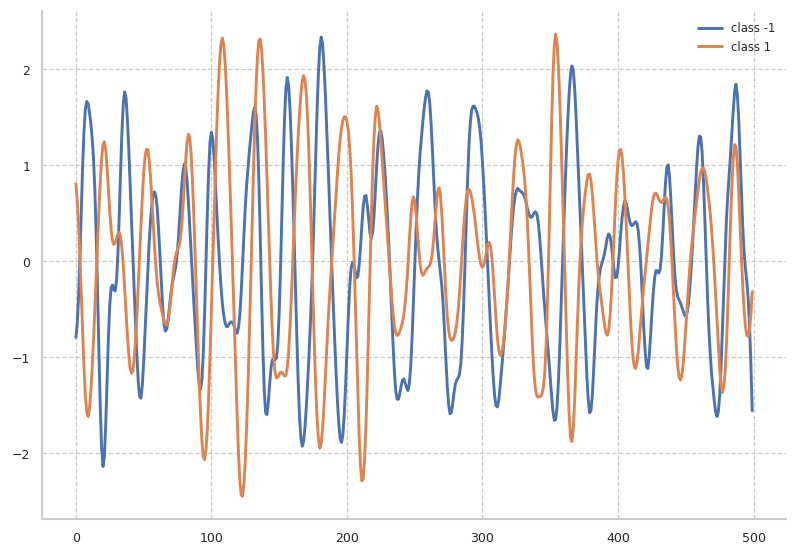

In [9]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

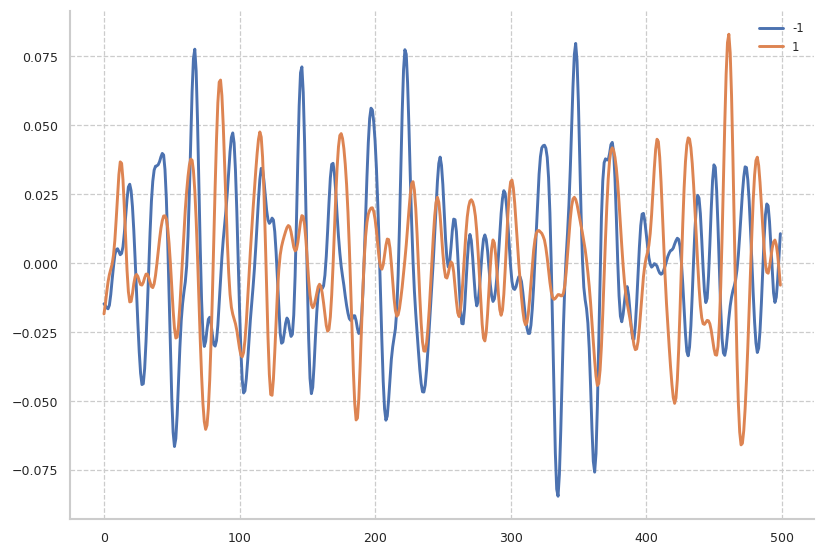

In [10]:
x_train_fault = x_train[y_train == -1]
x_train_nofault = x_train[y_train == 1]

plt.plot(x_train_fault.mean(axis=0), label="-1")
plt.plot(x_train_nofault.mean(axis=0), label="1")

plt.legend(loc="best")
plt.show()

In [11]:
x_train_df = pd.DataFrame(x_train.T)
x_test_df = pd.DataFrame(x_test.T)

ss = StandardScaler()

d_x_train_df = x_train_df.diff(axis=0).fillna(0)
d_x_test_df = x_test_df.diff(axis=0).fillna(0)

d_x_train_df = pd.DataFrame(data = ss.fit_transform(d_x_train_df))
d_x_test_df = pd.DataFrame(data = ss.fit_transform(d_x_test_df))

In [12]:
x_train_ = pd.concat([x_train_df,d_x_train_df],axis=0,ignore_index=True).T.values
x_test_ = pd.concat([x_test_df,d_x_test_df],axis=0,ignore_index=True).T.values

x_train_.shape

(3601, 1000)

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [13]:
x_train = x_train_.reshape((x_train_.shape[0], -1, 2))
x_test = x_test_.reshape((x_test_.shape[0], -1, 2))

In [14]:
x_train.shape,x_test.shape

((3601, 500, 2), (1320, 500, 2))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [15]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [16]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [17]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [18]:
x_train.shape,x_test.shape

((3601, 500, 2), (1320, 500, 2))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [19]:
num_classes = len(np.unique(y_train))
num_classes

2

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [20]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model:

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

#### Pure Conv Model

In [21]:
def make_model(input_shape):

    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 500, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 500, 64)             │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 500, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 500, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 500, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 500, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 500, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,050 (101.76 KB)

 Trainable params: 25,666 (100.26 KB)

 Non-trainable params: 384 (1.50 KB)

## Train the model

In [22]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss", mode="min"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001, mode="min"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min" ),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

#history = model.fit(
#    x_train,
#    y_train,
#    batch_size=batch_size,
#    epochs=epochs,
#    callbacks=callbacks,
#    validation_split=0.2,
#    verbose=1,
#)

In [23]:
#model.save('Models/Model_con_00.keras')
model = keras.models.load_model('Models/Model_con_00.keras')

## Evaluate model on test data

In [24]:
#model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9553
Test accuracy 0.9439393877983093
Test loss 0.1489277482032776


## Plot the model's training and validation loss

In [26]:
#metric = "sparse_categorical_accuracy"
#plt.figure()
#plt.plot(history.history[metric])
#plt.plot(history.history["val_" + metric])
#plt.title("model " + metric)
#plt.ylabel(metric, fontsize="large")
#plt.xlabel("epoch", fontsize="large")
#plt.legend(["train", "val"], loc="best")
#plt.show()
#plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.

## Predictions

In [27]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import confusion_matrix

In [28]:
preds = model.predict(x_test)[:,1]

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


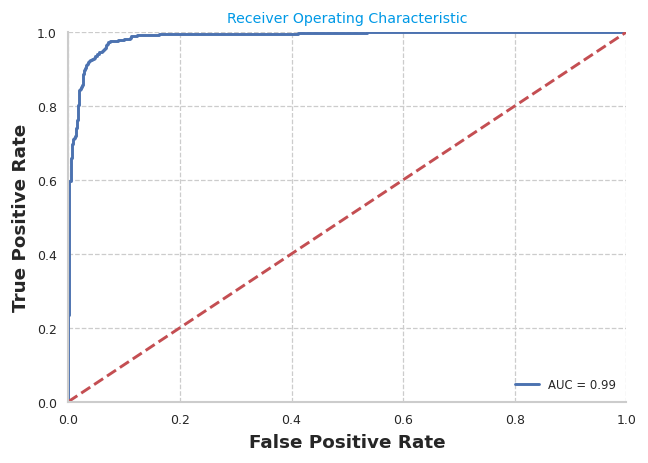

In [29]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
#plt.show()

In [30]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,4))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @ {:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Issue Detected (True Negatives): ', cm[0][0])
  print('No Issue Incorrectly Labelled (False Positives): ', cm[0][1])
  print('Issue Missed (False Negatives): ', cm[1][0])
  print('Issue Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

No Issue Detected (True Negatives):  639
No Issue Incorrectly Labelled (False Positives):  42
Issue Missed (False Negatives):  32
Issue Detected (True Positives):  607
Total Fraudulent Transactions:  639


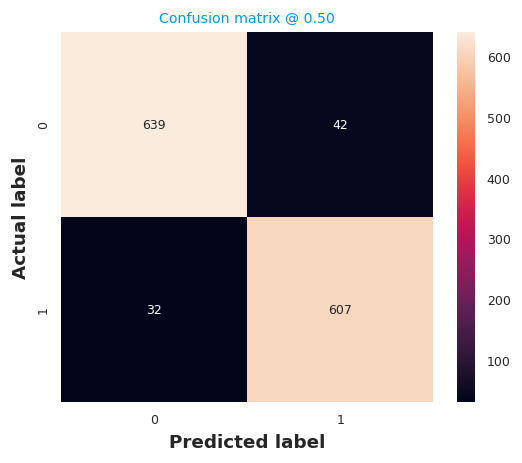

In [31]:
plot_cm(y_test, preds, threshold=0.5)

### Conv+RNN Model:

In [32]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=5, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    gap_conv = keras.layers.GlobalAveragePooling1D()(conv2)

    lstm1 = keras.layers.LSTM(64, return_sequences=True)(conv2)
    lstm2 = keras.layers.LSTM(64, return_sequences=True)(lstm1)
    lstm3 = keras.layers.LSTM(64, return_sequences=True)(lstm2)

    gap_rnn = keras.layers.GlobalAveragePooling1D()(lstm3)

    gap = keras.layers.Concatenate(name="gap_concat")([gap_rnn,gap_conv])
    gap = keras.layers.Dropout(0.33)(gap)

    d1 = keras.layers.Dense(128)(gap)
    d1 = keras.layers.BatchNormalization()(d1)
    d1 = keras.layers.ReLU()(d1)

    d2 = keras.layers.Dense(64)(d1)
    d2 = keras.layers.BatchNormalization()(d2)
    d2 =keras.layers.ReLU()(d2)

    output_layer = keras.layers.Dense(2, activation="softmax")(d2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer, name="Conv_RNN_Model")


model = make_model(input_shape=x_train.shape[1:])
model.summary(expand_nested=True)

Model: "Conv_RNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 500, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 500, 64)        │            704 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 500, 64)        │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 500, 64)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 500, 64)        │         12,352 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 500, 64)        │            256 │ conv1d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 500, 64)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 500, 64)        │         33,024 │ re_lu_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 500, 64)        │         33,024 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 500, 64)        │         33,024 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ lstm_2[0][0]           │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ re_lu_4[0][0]          │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gap_concat (Concatenate)  │ (None, 128)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ gap_concat[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         16,512 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128)            │            512 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 138,306 (540.26 KB)

 Trainable params: 137,666 (537.76 KB)

 Non-trainable params: 640 (2.50 KB)

In [33]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss", mode="min"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001, mode="min"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min" ),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

#history = model.fit(
#    x_train,
#    y_train,
#    batch_size=batch_size,
#    epochs=epochs,
#    callbacks=callbacks,
#    validation_split=0.2,
#    verbose=1,
#)

In [34]:
#model.save('Models/Model_con_rnn_00.keras')
model = keras.models.load_model('Models/Model_con_rnn_00.keras')

## Evaluate model on test data

In [35]:
#model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - loss: 0.2284 - sparse_categorical_accuracy: 0.9511
Test accuracy 0.946212112903595
Test loss 0.26856398582458496


## Plot the model's training and validation loss

In [36]:
#metric = "sparse_categorical_accuracy"
#plt.figure()
#plt.plot(history.history[metric])
#plt.plot(history.history["val_" + metric])
#plt.title("model " + metric)
#plt.ylabel(metric, fontsize="large")
#plt.xlabel("epoch", fontsize="large")
#plt.legend(["train", "val"], loc="best")
#plt.show()
#plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.

## Predictions

In [37]:
preds = model.predict(x_test)[:,1]

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step


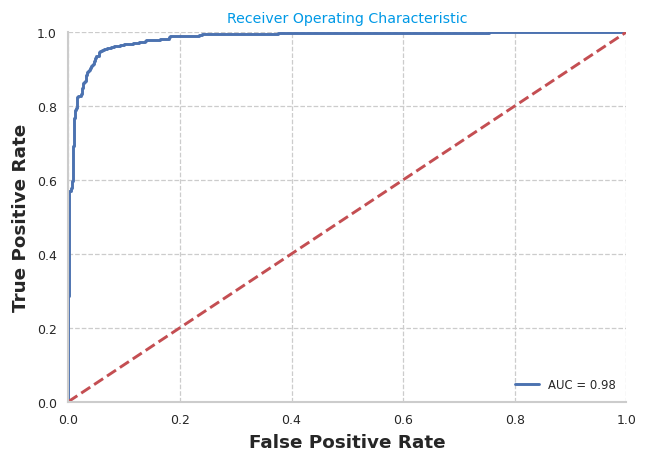

In [38]:
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
#plt.show()

In [39]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,4))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @ {:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Issue Detected (True Negatives): ', cm[0][0])
  print('No Issue Incorrectly Labelled (False Positives): ', cm[0][1])
  print('Issue Missed (False Negatives): ', cm[1][0])
  print('Issue Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

No Issue Detected (True Negatives):  642
No Issue Incorrectly Labelled (False Positives):  39
Issue Missed (False Negatives):  32
Issue Detected (True Positives):  607
Total Fraudulent Transactions:  639


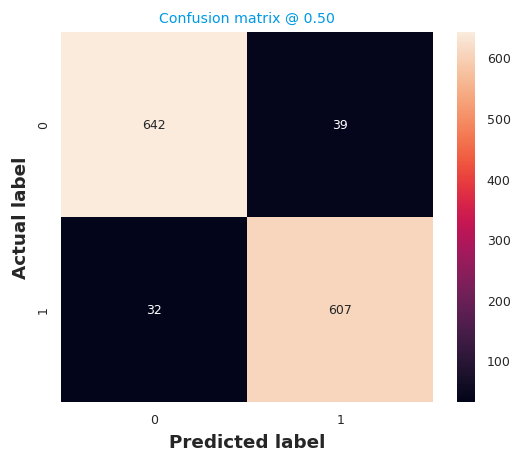

In [40]:
plot_cm(y_test, preds, threshold=0.50)

## KAN Model:

In [88]:
import keras
from keras.layers import Layer, Dense, TimeDistributed, Lambda

class UnivariateFunction(Layer):
    def __init__(self, units=32, **kwargs):
        super(UnivariateFunction, self).__init__(**kwargs)
        self.dense = Dense(units, activation='relu')

    def call(self, inputs):
        return self.dense(inputs)

class KANLayer(Layer):
    def __init__(self, num_series, **kwargs):
        super(KANLayer, self).__init__(**kwargs)
        self.univariate_functions = [UnivariateFunction() for _ in range(num_series)]
        self.combination_function = UnivariateFunction()

    def call(self, inputs):
        # Apply univariate functions to each series across all time steps
        transformed_series = [func(inputs[:, :, i]) for i, func in enumerate(self.univariate_functions)]
        # Combine the transformed features for each time step
        combined_features = Lambda(lambda x: keras.ops.sum(x, axis=0))(transformed_series)
        # Apply the combination function to the combined features across all time steps
        return self.combination_function(combined_features)

In [90]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = KANLayer(input_shape[1])(input_layer)
    #x = KANLayer(input_shape[1])(x)


    output_layer = keras.layers.Dense(2, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer, name="Conv_RNN_Model")


model = make_model(input_shape=list(x_train.shape[1:]))
model.summary(expand_nested=True)

Model: "Conv_RNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)          │ (None, 500, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kan_layer_34 (KANLayer)              │ (None, 32)                  │          33,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1175 (Dense)                   │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,186 (129.63 KB)

 Trainable params: 33,186 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
en(x_train.shape[1:])

2